# Мини задание 3

Продолжаем работать с задачкой на Kaggle про предсказание клика на рекламу - https://www.kaggle.com/c/avito-context-ad-clicks

В этот раз нужно уже полноценно решить поставленную задачу.

**1. [+5 баллов]** Из всех имеющихся данных необходимо составить датасет из **минимум 8 логических признаков**. Под логическим признаком имеется в виду то, что например кодирование категориального признака или текста в виде OheHot\BoW не считается за кучу признаков - конкретный текст считается за 1 признак, категориальный признак считается за 1 признак.

Всю работу по обработке данных и сборке финального датасета необходимо провести с помощью **спарка**.
Финальный датасет должен быть закодирован в **формате Vowpal Wabbit**.

**Важно** Следите за тем, чтобы исходное количество объектов не изменилось. При неаккуратной работе с join в sql вы можете начать терять какие-то записи, что плохо. Как минимум это означает, что вы не сможете собрать такие же признаки для тестовой выборки, которую предлагают в задаче.

**Важно** Обратите внимание, что в задаче стоит вопрос именно про контекстуальную рекламу, а не про всю существующую.

**2. [+5 баллов]** Разделите ваш датасет на обучающую и тестовую выборку. Обучите **логистическую регрессию** с помощью **Vowpal Wabbit**. 

Сделайте бинарные предсказания и посчитайте Accuracy, Presicion и Recall на тестовой выборке. 
Сделайне предсказания вероятностей и посчитайте LogLoss. (Эта же метрика используется в Kaggle для оценивания вашего решения).

Посчитайте ответы для тестовой выборки, которая предлагается в задании и отправьте в Kaggle (само соревнование уже давно закончилось, но вы все еще можете присылать туда свои решения и система будет вас оценивать). В решении приложите скриншот того, какой скор вам выдал Kaggle.

**3. [+ up to 5 дополнительных баллов]** Несмотря на то, что мы просим вас считать качество (и на тестовой и в Kaggle), оно никак **не будет влиять** на основные баллы. Основная цель этого задания состоит в том, чтобы вы потренировались в End-to-end работе с ML задачей на больших данных - от сбора датасета до получения модели и ее оценки. 

Однако, топ 5 студентов (в каждой группе отдельно) с самым больших качеством (по Kaggle) получат до 5 дополнительных баллов в зависимости от полученой метрики качества (за самое лучшее качество +5, за второе место +4 и так далее).

**Важно** В сдаваемом ноубуке должны присутствовать такие элементы
* Код на Spark, который собирает датасет
* Команды запуска VW для его обучения
* Подсчитанные метрики качества (и соответственно код, который их считает)
* Скриншот из Kaggle, на котором видно вашу посылку и подсчитанную метрику качества

In [11]:
%cd /Users/arinaruck/Desktop/cs/lsml/lsml-2021-public/

!pwd

/Users/arinaruck/Desktop/cs/lsml/lsml-2021-public
/Users/arinaruck/Desktop/cs/lsml/lsml-2021-public


In [12]:
%%bash

az login -u arina.ruck@gmail.com -p $(cat password-file.txt)
rm -r mhw3
mkdir -p mhw3

cd mhw3/

[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "fa34e92c-e581-439a-b6ae-b41b61270513",
    "id": "dfeaef04-2e5c-4480-8ebf-301863ed526a",
    "isDefault": true,
    "managedByTenants": [],
    "name": "Microsoft Azure Sponsorship 2",
    "state": "Disabled",
    "tenantId": "fa34e92c-e581-439a-b6ae-b41b61270513",
    "user": {
      "name": "arina.ruck@gmail.com",
      "type": "user"
    }
  },
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "fa34e92c-e581-439a-b6ae-b41b61270513",
    "id": "3750c13c-7871-4812-9fd5-94fb4ce86681",
    "isDefault": false,
    "managedByTenants": [],
    "name": "Lab1 21 Rak Arina Sergeevna",
    "state": "Enabled",
    "tenantId": "fa34e92c-e581-439a-b6ae-b41b61270513",
    "user": {
      "name": "arina.ruck@gmail.com",
      "type": "user"
    }
  }
]


In [13]:
%%writefile common.tf

provider "azurerm" {
  subscription_id = "3750c13c-7871-4812-9fd5-94fb4ce86681"
  features {}
}


resource "azurerm_resource_group" "lsml_rg" {
  name = "lsml-resource-group"
  location = "westus"
}

resource "azurerm_virtual_network" "lsml_vn" {
  name = "lsml-vitrual-network"
  resource_group_name = azurerm_resource_group.lsml_rg.name
  location = azurerm_resource_group.lsml_rg.location
  address_space = ["10.0.0.0/16"]   # Пул адресов внутри сети
}

resource "azurerm_storage_account" "lsml_sa" {
  name                     = "arinkalsmlstorage"
  resource_group_name      = azurerm_resource_group.lsml_rg.name
  location                 = azurerm_resource_group.lsml_rg.location
  account_tier             = "Standard"
  account_replication_type = "LRS"
}

Overwriting common.tf


In [14]:
%%writefile spark.tf

resource "azurerm_storage_container" "spark_sc" {
  name                  = "hw2-spark-container"
  storage_account_name  = azurerm_storage_account.lsml_sa.name
  container_access_type = "private"
}

resource "azurerm_hdinsight_spark_cluster" "spark_cluster" {
  name                = "hw2-sparkcluster"
  resource_group_name = azurerm_resource_group.lsml_rg.name
  location            = azurerm_resource_group.lsml_rg.location
  cluster_version     = "4.0"
  tier                = "Standard"

  component_version {
    spark = "2.4"
  }

  gateway {
    enabled  = true
    username = "azureuser"
    password = "Password123!"
  }

  storage_account {
    storage_container_id = azurerm_storage_container.spark_sc.id
    storage_account_key  = azurerm_storage_account.lsml_sa.primary_access_key
    is_default           = true
  }

  roles {
    head_node {
      vm_size  = "A6"  # 2 cpu 14 ram
      username = "azureuser"
      password = "Password123!"
    }

    worker_node {
      vm_size               = "Standard_D12_V2" # 4 cpu 28 ram
      username              = "azureuser"
      password              = "Password123!"
      target_instance_count = 1
    }

    zookeeper_node {
      vm_size  = "Medium"
      username = "azureuser"
      password = "Password123!"
    }
  }
}


output "ssh_endpoint" {
    value = azurerm_hdinsight_spark_cluster.spark_cluster.ssh_endpoint
}

output "https_endpoint" {
    value = azurerm_hdinsight_spark_cluster.spark_cluster.https_endpoint
}

output "jupyter_endpoint" {
    value = "${azurerm_hdinsight_spark_cluster.spark_cluster.https_endpoint}/jupyter"
}

Overwriting spark.tf


In [15]:
! terraform init


Initializing the backend...

Initializing provider plugins...
- Reusing previous version of hashicorp/azurerm from the dependency lock file
- Installing hashicorp/azurerm v2.45.1...
- Installed hashicorp/azurerm v2.45.1 (signed by HashiCorp)

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.


In [16]:
!terraform import azurerm_resource_group.lsml_rg /subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group
!terraform import azurerm_virtual_network.lsml_vn /subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group/providers/Microsoft.Network/virtualNetworks/lsml-vitrual-network
!terraform import azurerm_storage_account.lsml_sa /subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group/providers/Microsoft.Storage/storageAccounts/arinkalsmlstorage
!terraform import azurerm_storage_container.spark_sc https://arinkalsmlstorage.blob.core.windows.net/hw2-spark-container
    

azurerm_resource_group.lsml_rg: Importing from ID "/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group"...
azurerm_resource_group.lsml_rg: Import prepared!
  Prepared azurerm_resource_group for import

Error: Resource already managed by Terraform

Terraform is already managing a remote object for
azurerm_resource_group.lsml_rg. To import to this address you must first
remove the existing object from the state.

azurerm_virtual_network.lsml_vn: Importing from ID "/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group/providers/Microsoft.Network/virtualNetworks/lsml-vitrual-network"...
azurerm_virtual_network.lsml_vn: Import prepared!
  Prepared azurerm_virtual_network for import

Error: Resource already managed by Terraform

Terraform is already managing a remote object for
azurerm_virtual_network.lsml_vn. To import to this address you must first
remove the existing object from the state.

azurerm_storage_account.lsml_sa

In [17]:
! echo "yes" | terraform apply

azurerm_resource_group.lsml_rg: Refreshing state... [id=/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group]
azurerm_virtual_network.lsml_vn: Refreshing state... [id=/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group/providers/Microsoft.Network/virtualNetworks/lsml-vitrual-network]
azurerm_storage_account.lsml_sa: Refreshing state... [id=/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourceGroups/lsml-resource-group/providers/Microsoft.Storage/storageAccounts/arinkalsmlstorage]
azurerm_storage_container.spark_sc: Refreshing state... [id=https://arinkalsmlstorage.blob.core.windows.net/hw2-spark-container]

An execution plan has been generated and is shown below.
Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  # azurerm_hdinsight_spark_cluster.spark_cluster will be created
  + resource "azurerm_hdinsight_spark_cluster" "spark_cluster" {
   

azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 40s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 50s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 0s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 10s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 20s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 30s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 40s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 50s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 0s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 10s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 20s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 30s elapsed]
azurerm_hdinsight_spark_cluster.spark_cluster: Still creating... 4

# Часть 1

In [ ]:
from pyspark.sql import SparkSession, Row
sp = spark.sparkContext
se = SparkSession(sc)


%%configure -f
{
    "executorMemory": "20000M", 
    "executorCores": 6, 
    "numExecutors": 5,
    "conf": {
        "spark.sql.autoBroadcastJoinThreshold": -1
    }
}

Перезаливаю в паркет, как я понимаю, с ним легче работать spark.sql

In [ ]:
AdsInfo = spark.read.option("delimiter", "\t").csv('/data/AdsInfo.tsv', header=True)
SearchInfo = spark.read.option("delimiter", "\t").csv('/data/SearchInfo.tsv', header=True)
UserInfo = spark.read.option("delimiter", "\t").csv('/data/UserInfo.tsv', header=True)
trainSearchStream = spark.read.option("delimiter", "\t").csv('/data/trainSearchStream.tsv', header=True)
testSearchStream = spark.read.option("delimiter", "\t").csv('/data/testSearchStream.tsv', header=True)

AdsInfo.write.parquet("/data/parquet/AdsInfo.parquet")
SearchInfo.write.parquet("/data/parquet/SearchInfo.parquet")
UserInfo.write.parquet("/data/parquet/UserInfo.parquet")
trainSearchStream.write.parquet("/data/parquet/trainSearchStream.parquet")
testSearchStream.write.parquet("/data/parquet/testSearchStream.parquet")

AdsInfo = spark.read.parquet("/data/parquet/AdsInfo.parquet")
SearchInfo = spark.read.parquet("/data/parquet/SearchInfo.parquet")
UserInfo = spark.read.parquet("/data/parquet/UserInfo.parquet")
trainSearchStream = spark.read.parquet("/data/parquet/trainSearchStream.parquet")
testSearchStream = spark.read.parquet("/data/parquet/testSearchStream.parquet")

AdsInfo.registerTempTable('AdsInfo')
trainSearchStream.registerTempTable('trainStream')
testSearchStream.registerTempTable('testStream')
SearchInfo.registerTempTable('SearchInfo')
UserInfo.registerTempTable('UserInfo')

Возьму функцию для обработки search- и add- params из прошлого дз + функцию для обработки строк для wv и зарегистрирую их как udf

In [ ]:
import ast
import re


def get_params(params):
    params = params[1:-1]
    params = re.sub(r"\{[^{}]*\}", "0", params)
    params = re.sub(r"\[[^\[\]]*\]", "0", params)
    param_dict = ast.literal_eval("{" + params + "}")
    values = map(str, param_dict.values())
    full_params = (' '.join(values)).lower()
    word_pattern = re.compile(r"[а-яё0-9a-z_]+")
    words = [match.group(0) for match in re.finditer(word_pattern, full_params)]
    return ' '.join(words)
    
    
def process_str(x):
    word_pattern = re.compile(r"[а-яё0-9a-z_]+")
    x = x.lower()  
    words = [match.group(0) for match in re.finditer(word_pattern, x)]
    x = ' '.join(words)
    return x

spark.udf.register("get_params", get_params, "string")
spark.udf.register("process_str", process_str, "string")

Признаки я выбрала из трех Info таблиц SearchInfo, AdsInfo, UserInfo:

Дата поиска SearchDate — взяла как категориальный признак, так как в данных всего 16 последовательных дней

Текст запроса SearchQuery — использовала как bag of words

Залогинен ли пользватель IsUserLoggedOn — может быть важно для контекстной рекламы

Фильтры поиска SearchParams — значения из словаря с фильтрами поиска (использую как bag of words)

Фильтры объявления AdParams — значения из словаря с фильтрами рекламы (использую как bag of words)

Цена товара Price — единственный численный признак

Название объявления Title — опять bag of words

ID девайса, с которого зашел пользователь UserDeviceID — возможно с айфонов или нокиа по-разному кликают (возможно нет)

Семейство браузеров UserAgentFamilyID — на всякий случай

Выбираю нужные признаки из каждой таблицы:

In [ ]:
spark.sql(
    """
    select 
        SearchID, 
        UserID,
        date(SearchDate) as SearchDate, 
        process_str(nvl(SearchQuery, "")) as SearchQuery, 
        IsUserLoggedOn, 
        get_params(nvl(SearchParams, "{}")) as SearchParams
    from SearchInfo
    """
).registerTempTable('si')

spark.sql(
    """
    cache lazy table si
    """
)

In [ ]:
spark.sql(
    """
    select
        AdID, 
        get_params(nvl(Params, "{}")) as AdParams, 
        nvl(Price, 0) as Price, 
        process_str(nvl(Title, "")) as Title 
    from AdsInfo
    where IsContext = 1
    """
).registerTempTable('ai')

spark.sql(
    """
    cache lazy table ai
    """
)

In [ ]:
spark.sql(
    """
    select
        UserID,
        UserAgentFamilyID,
        UserDeviceID 
    from UserInfo
    """
).registerTempTable('ui')

spark.sql(
    """
    cache lazy table ui
    """
)

И собираю из них тестовую и обучающую выборки (количество объектов сохранилось)

In [ ]:
spark.sql("""
    with search_user as (
        with search_train as ( 
            select ts.SearchID, ts.AdID, nvl(ts.Position, "") as Position, ts.IsClick, si.*
            from 
                trainStream as ts left join si on ts.SearchID = si.SearchID
            where ts.IsClick is not null
        )
        select *
        from 
            search_train as st left join ui on st.UserID = ui.UserID
    )
    select 
        (IsClick * 2 - 1) as IsClick,
        AdParams, Price, Title as Title,
        SearchParams, SearchDate, SearchQuery as SearchQuery, IsUserLoggedOn,
        UserAgentFamilyID, UserDeviceID, 
        Position
    from 
        search_user AS su left join ai on su.AdID = ai.AdID
""").registerTempTable('train_set')

In [ ]:
spark.sql(
    """
    select *
    from train_set
    """
).write.parquet("/data/parquet/TrainSet.parquet")

In [ ]:
spark.sql("""
    with search_user as (
        with search_test as ( 
            select ts.SearchID, ts.AdID, nvl(ts.Position, "") as Position, si.*
            from 
                testStream as ts left join si on ts.SearchID = si.SearchID
            where ts.HistCTR is not null
        )
        select *
        from 
            search_test as st left join ui on st.UserID = ui.UserID
    )
    select 
        AdParams, Price, Title as Title,
        SearchParams, SearchDate, SearchQuery as SearchQuery, IsUserLoggedOn,
        UserAgentFamilyID, UserDeviceID, 
        Position
    from 
        search_user AS su left join ai on su.AdID = ai.AdID
""").registerTempTable('test_set')

In [ ]:
spark.sql(
    """
    select *
    from test_set
    """
).write.parquet("/data/parquet/TestSet.parquet")

Заодно записываю ID-шки для теста в отдельный файл, чтобы потом приклеить к ним предсказания

In [ ]:
spark.sql(
    """
    select ID
    from testStream
    where HistCTR is not null
    """
).write.csv('/data/ids')

In [ ]:
%%bash

hdfs dfs -getmerge /data/ids/part* /var/lib/jupyter/vw_data/ids.csv

## Перевод в vw

Тут я очень хотела использовать импортансы, так как классы очень несбалансированные, и добавила их в виде total_num_examples / total_examples_of_this_class. Там получились числа вида 1 и 160 из-за чего модель сильно переобучилась на класс 1 и дала предсказание порядочно хуже константого. Думаю, можно было бы поэксперементировать с менее радикальными значениями импортанса, но я уже не могу.

In [ ]:
from functools import partial

def convert_to_vw(data, split='train'):
    
    target = data['IsClick'] if split == 'train' else -1
    importance = pos_imp if target == 1 else neg_imp
    
    title = data['Title']
    params = data['AdParams']
    price = data['Price'] if data['Price'] is not None else 0
    
    s_query = data['SearchQuery']
    s_date = data['SearchDate']
    s_params = data['SearchParams']
    is_logged = data['IsUserLoggedOn']
    
    UserAgentFamilyID = data['UserAgentFamilyID']
    UserDeviceID = data['UserDeviceID']
    
    position = data['Position']
    
    template = "{target} |t {title} |a {params} |p price:{price} |q {s_query} |s {s_params} |d {s_date} \
                |l logged:{is_logged} |f {UserAgentFamilyID} |d {UserDeviceID} |p {position}"
    
    return template.format(
        target=target,
        title=title,
        params=params,
        price=price,
        s_query=s_query,
        s_date=s_date,
        s_params=s_params,
        is_logged=is_logged,
        UserAgentFamilyID=UserAgentFamilyID,
        UserDeviceID=UserDeviceID,
        position=position,

    )

test_convert_to_vw = partial(convert_to_vw, split='test')

In [ ]:
df = spark.read.parquet("/data/parquet/TrainSet.parquet")
test_df = spark.read.parquet("/data/parquet/TestSet.parquet")
# тут я хотела сделать stratified split, не уверена, какой способ лучше
train_df = df.sampleBy("IsClick", fractions={-1: 0.8, 1: 0.8}, seed=1992)
val_df = df.subtract(train_df)

train_df.rdd.map(convert_to_vw).saveAsTextFile('/data/train.vw')
val_df.rdd.map(convert_to_vw).saveAsTextFile('/data/val.vw')
test_df.rdd.map(test_convert_to_vw).saveAsTextFile('/data/test.vw')

In [ ]:
%%bash

rm -r /var/lib/jupyter/vw_data
mkdir /var/lib/jupyter/vw_data
hdfs dfs -getmerge /data/train.vw/part* /var/lib/jupyter/vw_data/train.vw
hdfs dfs -getmerge /data/val.vw/part* /var/lib/jupyter/vw_data/val.vw
hdfs dfs -getmerge /data/test.vw/part* /var/lib/jupyter/vw_data/test.vw

# Часть 2

In [ ]:
%%writefile get_metrics.py
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
import numpy as np 
import sys

def read_from_vw(vw_record):
    return float(vw_record.split('|')[0].strip())
    
    
def compute_metrics(predictions_filename, labels_filename):
    with open(predictions_filename, 'r') as f:
        probs = np.array([float(value) for value in f.readlines()])
        
    with open(labels_filename, 'r') as f:
        labels = np.array([read_from_vw(value) for value in f.readlines()])
        
    preds = np.round(probs) * 2 - 1 # из вероятностей в [-1, 1]
    
    template = "accuracy: {acc}, precision: {prec}, recall: {rec}, roc auc: {roc_auc}, pr auc: {pr_auc}"
    print(template.format(
        acc=accuracy_score(labels, preds),
        prec=precision_score(labels, preds),
        rec=recall_score(labels, preds),
        roc_auc=roc_auc_score(labels, probs),
        pr_auc=average_precision_score(labels, probs)
    ))

preds, labels = argv[1], argv[2]
compute_metrics(preds, labels)

In [ ]:
%%bash 

wget --user azureuser http://finance.yendor.com/ML/VW/Binaries/vw-8.20190624 -O /usr/bin/vw
chmod +x /usr/bin/vw

vw /var/lib/jupyter/vw_data/train.vw \
    --final_regressor model.bin \
    --loss_function logistic \
    --learning_rate 0.5 \
    --bit_precision 22 \
    --passes 5 \
    --cache -k \
    --ngram s2 t2 a2
    
vw /var/lib/jupyter/vw_data/val.vw \
    --predictions val_preds.txt \
    --initial_regressor model.bin \
    --testonly \
    --link logistic
    --loss_function logistic
    
vw /var/lib/jupyter/vw_data/test.vw \
    --predictions test_preds.txt \
    --initial_regressor model.bin \
    --testonly \
    --link logistic
    --loss_function logistic
    
#считаем метрики    
python get_metrics.py val_preds.txt /var/lib/jupyter/vw_data/val.vw

#записываем в общий файл и засылаем на кеггл
echo ID,IsCLick > kaggle_answers.csv
sudo sh -c "paste -d "," /var/lib/jupyter/vw_data/ids.csv test_preds.txt >> kaggle_answers.csv"
kaggle competitions submit -f kaggle_answers.csv -m 'first try' -c avito-context-ad-clicks

accuracy: 0.925, precision: 0.176, recall: 2.72e-05, roc auc: 0.71, pr auc: 0.16

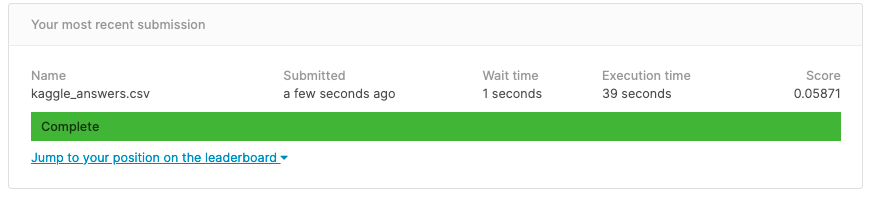